# 'Model Fitness' Member Churn Predictions

**Objective**

Model Fitness wants to develop a more effective customer retention strategy. To acheive this, we must first understand what factors have the strongest impact on churn. What makes members continue at Model Fitness? What drives them away?

**Overview**

Using data on existing customers (both active and inactive), we will explore several features to create a model to predict the probability of customer churn. We will then cluster customers into groups to further our understanding of customer types and the features that define them. Our aim is to use this information to help reduce churn in the future.

## Description of Data

**File: `gym_churn_us`**
- **Churn:** has the member left as of the current month
- **gender:** customer's gender
- **Near_Location:** whether the member lives/works in the neighborhood where the gym is located
- **Partner:** whether the user is an employee of a partner company (discounted membership)
- **Promo_friends:** whether the user originally signed up through a "bring a friend" offer, using another member's promo code upon signing up
- **Phone:** whether the user provided their phone number
- **Age:** member's age in years
- **Lifetime:** number of months since the customer's first visit
- **Contract_period:** length of the contract; 1 month, 3 months, 6 months, or 12 months
- **Month_to_end_contract:** the months remaining until the current contract expires
- **Group_visits:** whether the user takes part in group sessions
- **Avg_class_frequency_total:** average number of weekly visits over the *customer's lifetime*
- **Avg_class_frequency_current_month:** average number of weekly visits over the *preceding month*
- **Avg_additional_charges_total:** the total amount of money spent on other gym services (cafe, athletic goods, cosmetics, massages, etc.)

<a class = "anchor" id="toc"></a>
## Table of Contents

* 1. [Read files & import libraries](#read_import)
* 2. [General exploration of data](#explore)
* 3. [Pre-processing](#preprocess)
* 4. [Exploratory analysis](#eda)
    * 4.1 [Mean feature values for churned vs active customers](#mean_feat)
    * 4.2 [Feature distributions](#feat_dist)
    * 4.3 [Correlation matrix](#corr)
* 5. [Build a model to predict user churn](#model)
* 6. [Member clustering](#cluster)
    * 6.1 [Identify member clusters](#id_clusters)
    * 6.2 [Cluster features](#cluster_feat)
* [Final conclusions](#conclusions)

<a class="anchor" id="read_import"></a>
## 1. Read files & import libraries

In [1]:
# The following libraries may need to be installed/updated to run the notebook

#!pip install sidetable
#!pip install seaborn==0.11.2

In [2]:
import pandas as pd
import warnings
import numpy as np
import scipy.stats as st
import math as mth
import sidetable as stb
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Read raw data
file_path= 'gym_churn_us.csv'
gym_raw = pd.read_csv(file_path)

[Return to Table of Contents](#toc)

<a class="anchor" id="explore"></a>
## 2. General exploration of file

In [5]:
#Look at the first 5 rows
gym_raw.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


There are several **binary** columns present: gender, Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn. It is unclear which number corresponds to which gender.

In [6]:
gym_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

There appear to be no nulls.

In [7]:
gym_raw.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [8]:
#Contract period
gym_raw.stb.freq(['Contract_period'])

,Contract_period,count,percent,cumulative_count,cumulative_percent
0,1,2207,55.175,2207,55.175
1,12,960,24.000,3167,79.175
2,6,833,20.825,4000,100.000


Though there is a 3-month membership option, there are **no customers with 3-month membership**.

In [9]:
# Search for duplicates
print('Number of duplicated rows:', gym_raw.duplicated().sum())

Number of duplicated rows: 0


<b>Notes:</b>

Overall, the data appears to be clean. There are no null/missing values, no duplicated rows, & no unusual values (negative values, strange ages, unreasonable class frequency, etc)

It is unknown which values in 'gender' correspond to male or female, but there is an almost even split. We will assume this split accurately represents the gym's actual member base.

Values in the column **'Month_to_end_contract**' should be int, since all values represent whole months. Otherwise, all data types appear to be appropriate.

[Return to Table of Contents](#toc)

<a class="anchor" id="preprocess"></a>
## 3. Pre-processing

Update column names and data types.

In [10]:
#Create a copy of the original dataframe
gym_churn = gym_raw.copy()

In [11]:
#Rename columns for simplicity & readability
gym_churn.columns = ['gender', 'near_loc','partner', 'friend_promo', 'phone', 'contract',
                       'group_classes','age','avg_add_chrgs', 'months_remain','lifetime',
                       'avg_class_freq_total','avg_class_freq_cmonth','churn']

In [12]:
#Change 'months_remain' to an integer type
gym_churn['months_remain'] = gym_churn['months_remain'].astype('int64')
gym_churn['contract'] = gym_churn['contract'].astype('category')

In [13]:
#Check changes for the new df
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 4000 non-null   int64   
 1   near_loc               4000 non-null   int64   
 2   partner                4000 non-null   int64   
 3   friend_promo           4000 non-null   int64   
 4   phone                  4000 non-null   int64   
 5   contract               4000 non-null   category
 6   group_classes          4000 non-null   int64   
 7   age                    4000 non-null   int64   
 8   avg_add_chrgs          4000 non-null   float64 
 9   months_remain          4000 non-null   int64   
 10  lifetime               4000 non-null   int64   
 11  avg_class_freq_total   4000 non-null   float64 
 12  avg_class_freq_cmonth  4000 non-null   float64 
 13  churn                  4000 non-null   int64   
dtypes: category(1), float64(3), int64(10)
me


The new copy of the dataframe `gym_churn` is largely unchanged. <br>

<b>Please note that:</b><br>
* 'avg_class_freq_total' is the average number of group classes attended per week over the member's lifetime <br>
* 'avg_class_freq_cmonth' is the average number of group classes attended per week in the most recent month (cmonth = current month)


[Return to Table of Contents](#toc)

<a class="anchor" id="eda"></a>
## 4. Exploratory Analysis

In [14]:
#Descriptive stats on all features
gym_churn.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_loc,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
friend_promo,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
group_classes,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_add_chrgs,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
months_remain,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00
lifetime,4000.0,3.72,3.75,0.00,1.00,3.00,5.00,31.00


In [15]:
#Print contract types and the share of each type
gym_churn.stb.freq(['contract'])

,contract,count,percent,cumulative_count,cumulative_percent
0,1,2207,55.175,2207,55.175
1,12,960,24.000,3167,79.175
2,6,833,20.825,4000,100.000


* **Gender** appears to be fairly evenly split
* The majority of members **(84.5%) live/work close to the gym**. This choice seems to be based on geographic convenience.
* Nearly half of all members in the set are part of a partner program. This program seems to be effective for bringing members in.
* **30%** of members originally joined as part of a **"Bring a Friend"** promotion. This strategy also seems to be effective for recruiting nnew members.
* We have phone data for over 90% of customers. Basic customer contact is expected to be on file.
* 3-month contracts are either no longer in use, or customers prefer other options. 55% of customers opted for a 1-month contract. Full year contracts are the next most popular at 24%, followed by the 6-month contract at 20.1%. These options are still very popular.
* **41%** of members attend **group classes**.
* Members average roughly 2 group sessions per week, with some super-humans averaging 6 sessions per week. However we can see this engagement drop slightly in the most recent month.
* Customer age ranges from 18 (lowest legal adult age) to 41 years old, with an average age of 29. The mean & median are close, suggesting a possible normally distributed age range.
* Additional charges range from an average of only \\$0.15 to \\$553 with a mean of \\$147. High-spending customers appear to skew average charges slightly to the right.
* On average, customer's have 4 months remaining on their contracts. However, we can see that at least 50\% of customers only have one month remaining. This lines up with the fact that over half of our customer's are on 1-month contracts.
* We have customers that range from brand new at 0 months, up until loyal customers of 31 months (roughly 2.5 years). On average, customer's have a lifetime of 3-4 months.
* **26.5\% of members** in our set are already considered **churned**. 

[Return to Table of Contents](#toc)

<a class="anchor" id="mean_feat"></a>
### 4.1 Mean feature values for churned vs active customers

In [16]:
#Mean values of each feature for each churn group
gym_churn.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_loc,0.873086,0.768143
partner,0.534195,0.355325
friend_promo,0.353522,0.183789
phone,0.903709,0.902922
group_classes,0.464103,0.268615
age,29.976523,26.989632
avg_add_chrgs,158.445715,115.082899
months_remain,5.283089,1.662582
lifetime,4.711807,0.990575


* Gender is equal between active & inactive members
* Convenience appears to have a large role in continued membership. Active members are much more likely to be part of a partner program and to live/work nearby.
* The social aspect of the gym also seems to have an impact. Active members and are twice as likely to have joined with a friend, are more likely to partake in group classes, and attend more classes on average than churned members.
* Active members are more likely to have long-term contracts, suggesting they uphold this commitment. Churned members have a much lower average lifetime. Our loyal customers appear to remain loyal.

[Return to Table of Contents](#toc)

<a class="anchor" id="feat_dist"></a>
### 4.2 Feature Distributions 

Compare the prevalance of binary features in active & inactive members.

**Separate features**

In [17]:
#List of column names for categorical features
cat_feat = ['gender','near_loc','partner','friend_promo','phone', 'group_classes']

#Aggregated table of all binary features separate by churn
bool_feats = (gym_churn.groupby('churn').mean()[cat_feat]
                       .T.stack()
                       .reset_index()
             )
bool_feats.columns=['feat','churn','mean']

#Dictionary of column names for quantitative features
#Values for labelling purposes
quant_feat = {'age': 'age',
              'avg_add_chrgs': 'additional charges',
              'months_remain': 'months remaining',
              'lifetime': 'lifetime',
              'avg_class_freq_total':'total class frequency',
              'avg_class_freq_cmonth': 'current class frequency'
             }

In [18]:
#Slices of active & inactive customer data
active_data = gym_churn[gym_churn.churn == 0]
inactive_data = gym_churn[gym_churn.churn == 1]

**Graph styling**

In [19]:
#Set graph style
sns.set_style("whitegrid")
#Define palette for churn status
churn_palette = {0:'springgreen' , 1:'crimson'}

#### 4.2.1 Plot categorical features

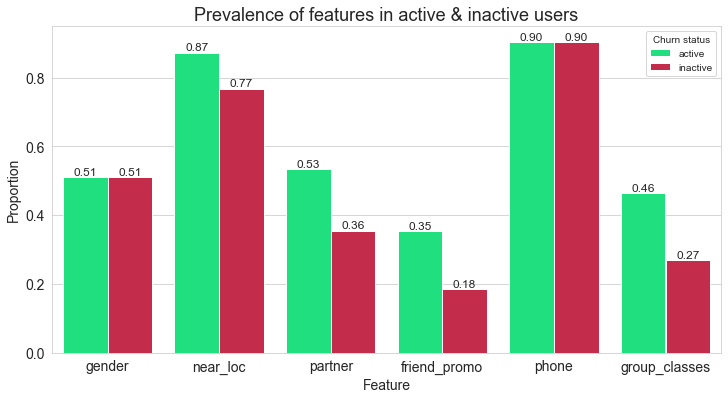

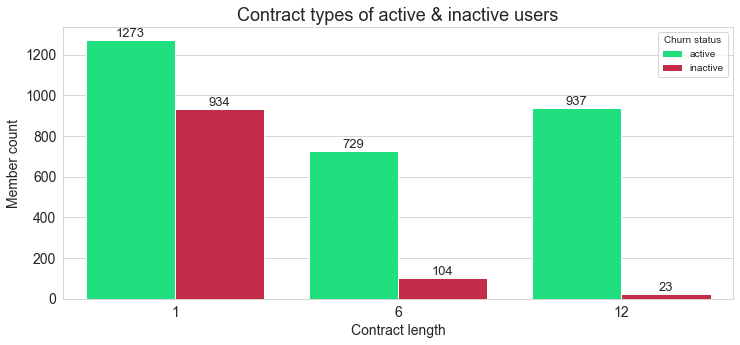

In [20]:
#Graph means of all binary features
fig = plt.figure(figsize=(12,6))
ax = sns.barplot(data=bool_feats, x='feat', y='mean',
                 hue='churn', palette = churn_palette
                )
#Titles & labels
plt.title('Prevalence of features in active & inactive users', size=18)
plt.tick_params(labelsize = 14)
plt.xlabel('Feature', size=14)
plt.ylabel('Proportion', size=14)

#Annotate bars
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', size=12)

#Update legend
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['active','inactive'] , title="Churn status"
         )

plt.show();


#Graph distribution of contract types
fig = plt.figure(figsize=(12,5))  
ax = sns.countplot(data = gym_churn, palette = churn_palette,
                   x = 'contract', hue='churn'
                  )

#Titles & labels
plt.title('Contract types of active & inactive users', size=18)
plt.tick_params(labelsize = 14)
plt.xlabel('Contract length', size=14)
plt.ylabel('Member count', size=14)

#Annotate bars
for bars in ax.containers:
        ax.bar_label(bars, size=13)

#Update legend
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['active','inactive'] , title="Churn status"
         )

plt.show();

<b>Notes</b>
* **gender:** the distribution of genders looks similar between active & inactive members
* **near_loc:** A higher percentage of people who stopped going to the gym lived inconveniently far away. 
* **partner:** more than half of active member were part of a partner program. However, only 36% of inactive members were part of partner programs.
* **friend_promo:** less than a fifth of inactive members were brought in through a friend. Twice as many active members began their memberships this way. It seems like have a workout buddy may keep people motivated.
* **phone:** overall, most members have phone information on file regardless of churn status
* **group_class:** inactive users attended group classes at a lower rate than active users.
* **contract:** in both cases, 1-month contracts are the most common. 1-year contracts are the 2nd most common overall, but have the fewest instances of churn. Members with 6 month contracts are the least common, but had more inactive members than 1-year contracts. Though they still seem more likely to stay than 1-month contracts.


[Return to Table of Contents](#toc)

#### 4.2.2 Plot histograms of quantitative features

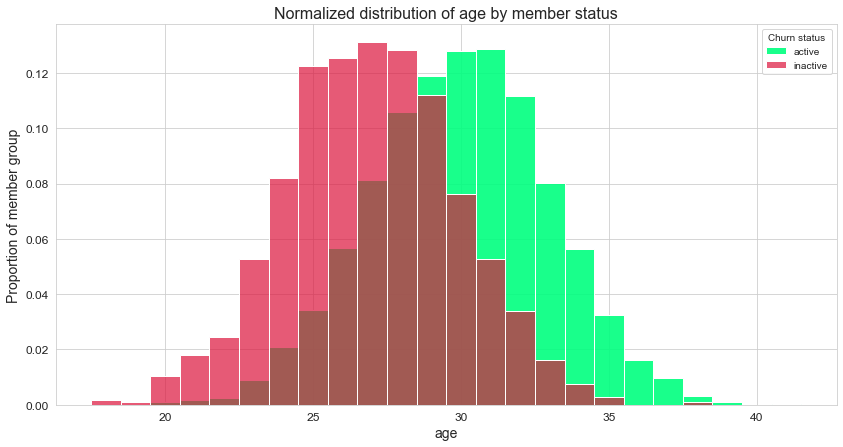

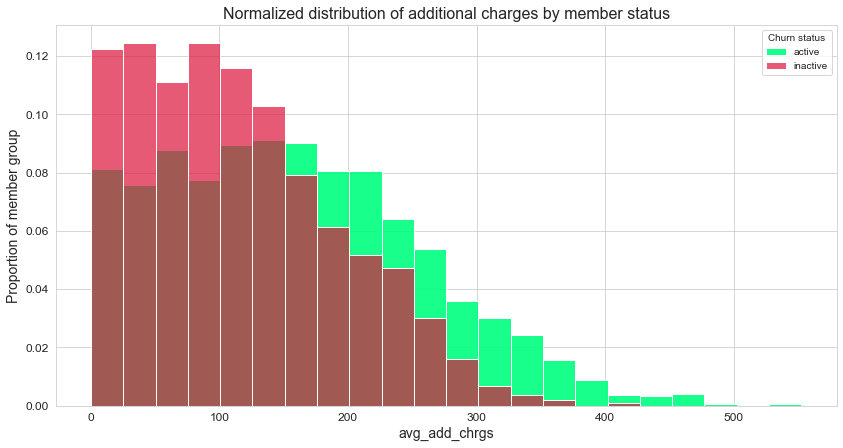

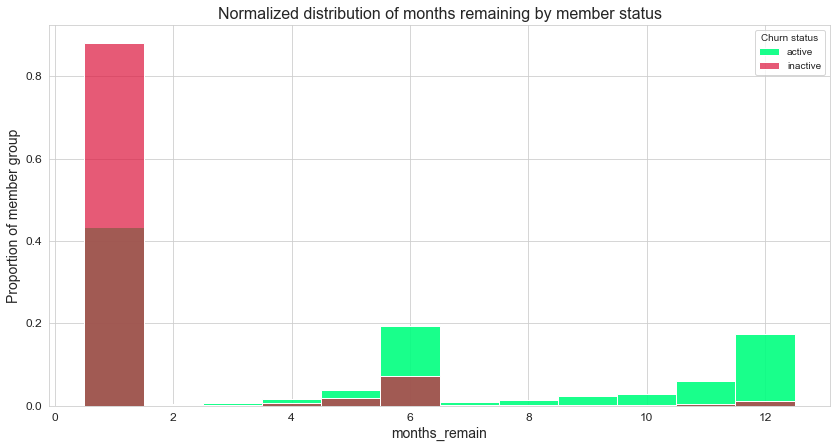

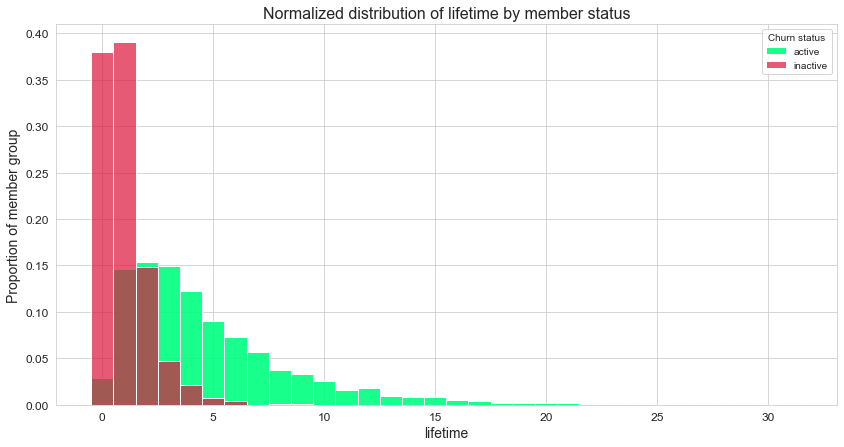

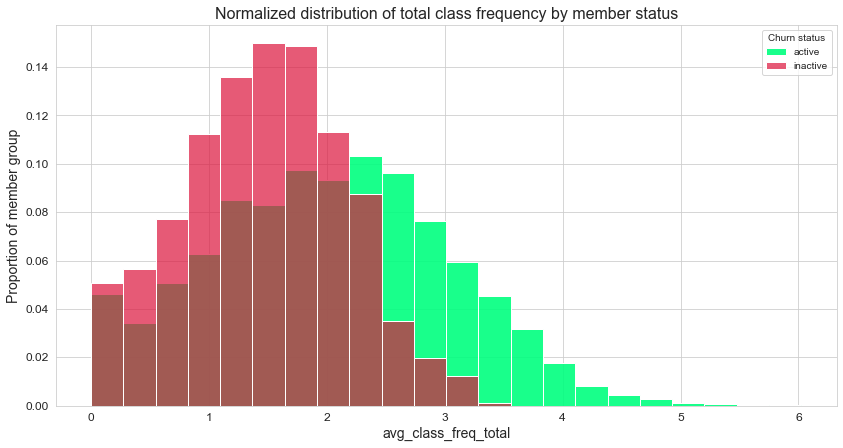

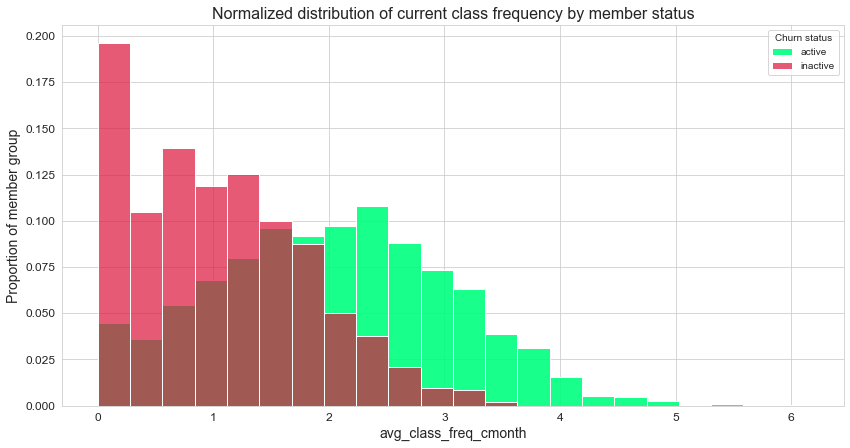

In [21]:
#Iterate through all quantitative features
for feat in quant_feat.keys():
    
    #Set bins equal for the active & inactive hist
    bins = np.histogram(np.hstack((active_data[feat],inactive_data[feat])))[1]
    
    #Specify discrete histograms
    if feat in ['age','months_remain','lifetime']:
        discrete = True
    else:
        discrete = False
        #double the number of bins for continuous hists
        nbin = len(bins)*2
        bins = np.histogram(np.hstack((active_data[feat],inactive_data[feat])), bins=nbin)[1]

    #Plot feature hist
    fig, ax = plt.subplots(figsize = (14,7))
    #Hist for active members
    sns.histplot(data = active_data, x = feat, bins = bins,
                 stat = 'proportion', discrete = discrete,
                 color = 'springgreen', label = 'active', alpha = .9
                )
    #Hist for churned members
    sns.histplot(data = inactive_data, x = feat, bins=bins,
                 stat = 'proportion', discrete = discrete,
                 color = 'crimson', label = 'inactive', alpha = .7
                )
    #Title & labels
    title = 'Normalized distribution of {} by member status'.format(quant_feat[feat])
    ax.set_title(title, size=16)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(feat, size=14)
    ax.set_ylabel('Proportion of member group',size=14)

    #Show legend with title
    plt.legend(title = 'Churn status')
    plt.show();

<b>Notes:</b>
* **age:** the ages of active & inactive members both have a roughly normal distribution. But inactive members tended to be younger.
* **avg_add_chrgs:** active members have a wider distribution of average additional charges. These members are generally at the gym more often using the services, so they are present more to sped this money.
* **months_remain:** churned members are almost exclusively left with only 1 month, with few exceptions. 
* **lifetime:** members who stopped going to the gym are overwhelmingly short-term members, with most being members for a month or less. There are almost no members who churned part the 5 month mark. We may be able to expect customers who make it past 2 months to continue.
* **avg_class_freq_total & avg_class_freq_cmonth:** For both the customer's lifetime and for the most current month, active members clearly tend to have attended more group classes on average. Comparing the total & recent month, active members maintain a similar distribution. However, those who have left have a decrease in classes in their final active month, with a notable spike around 0. A decrease in class attendance may be an indicator that a customer is on their way out.

[Return to Table of Contents](#toc)

<a class="anchor" id="corr"></a>
### 4.3 Feature correlations

Build a correlation matrix of all features. Plot correlations as a heatmap for easier assessment.

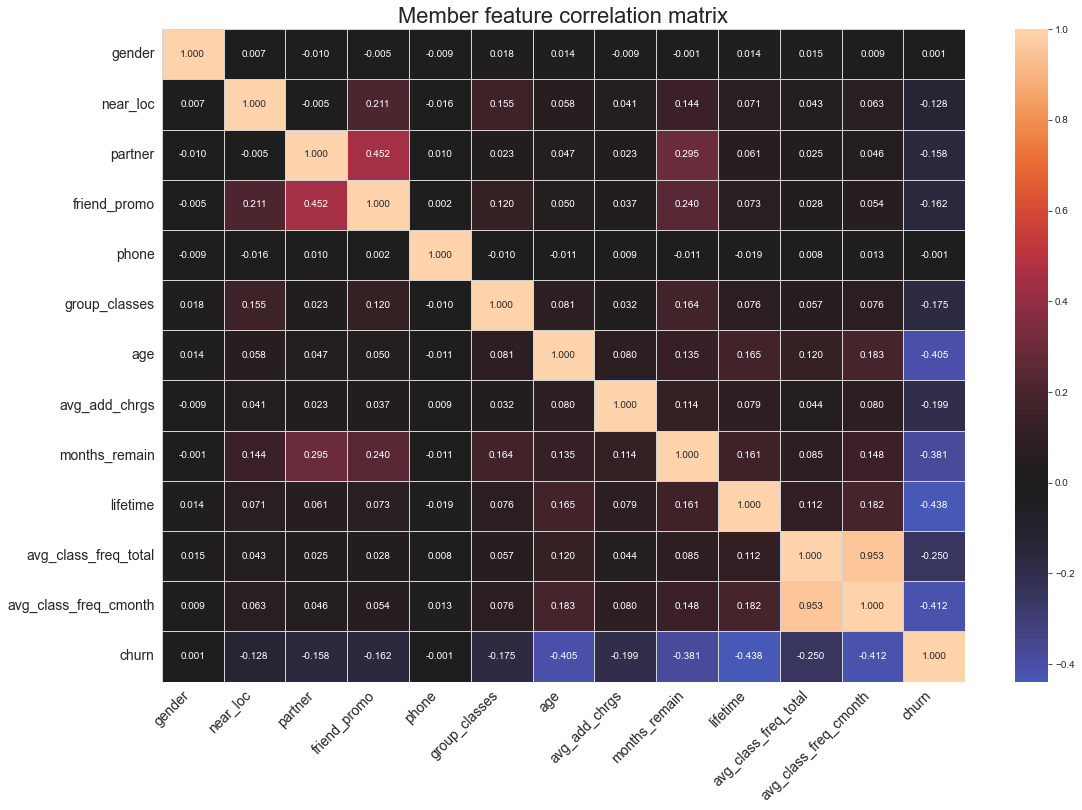

In [22]:
#Define the correlation matrix
corr_matrix = gym_churn.corr()

#Plot correlations as a heatmap
plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix, annot = True, fmt = '.3f',
            linewidths = 1, linecolor = 'lightgrey',
            cmap = 'icefire',  center = 0
           )
#Title & labels
plt.title('Member feature correlation matrix', size = 22)
plt.xticks(rotation = 45, ha = 'right')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

<b>Notes</b>
    
Overall, member lifetime has the highest correlation with churn. This is followed by the average number of classes attended in the most recent month, and then age.
    
Contract & months remaining on the contract are highly correlated. Most members are on a one-month contract, which directly affects the number of possible remaining months. To avoid over-fitting, we will not consider months_remain in our calculations.
    
Members who signed up as part of a bring-a-friend promotion seem to be correlated with members who have a partnership deal. This could be a case of friends having similar partnerships available to them through common work places. This suggests a good combination for bringing in new members.
    
There is also a moderate correlation between partner status & contract type. It is possible that partners are more likely to commit to longer contracts.
    
<b>In our predictive model, we will not consider the following features:</b>
* gender & phone: These seem to have no correlation to churn
* months_remain: As stated above, it is too highly correlated with contract.
* avg_class_freq_total: Very highly correlated with the average number of classes in the most recent month, but avg_class_freq_cmonth has a higher correlation to churn overall and is therefore more relevant.
* group_classes: The average number of classes will give us a better sense of member behavior, while still telling us whether or not the member attends classes.

<b>The remaining features for our model:</b> near_loc, partner, friend_promo, contract, age, avg_add_chrgs, lifetime, avg_class_freq_cmonth
</div>

[Return to Table of Contents](#toc)

<a class='anchor' id='model'></a>
## 5. Build a model to predict user churn

 Build a binary classification model for customers where the target feature is the user's leaving next month.
- Divide the data into train and validation sets using the train_test_split() function.
- Train the model on the train set with two methods:
    - logistic regression
    - random forest
- Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?
- Remember to indicate the random_state parameter when dividing data and defining the algorithm.

In [23]:
# List of relevant features
model_feat = ['near_loc', 'partner', 'friend_promo', 
              'contract', 'age', 'avg_add_chrgs', 
              'lifetime', 'avg_class_freq_cmonth']
# Feature matrix
X = gym_churn[model_feat]
# Target variable
y = gym_churn['churn']

In [24]:
# Standardize features
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [25]:
# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=.2, random_state=0)

In [26]:
# Train logistic regression model
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train,y_train)
lr_ypred = lr_model.predict(X_test)

In [27]:
#Train random forest classifier model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train,y_train)
rf_ypred = rf_model.predict(X_test)

In [28]:
#Method to caulculate and print accuracy, precision, & recall of a model
def model_eval(y_pred):
    #accuracy
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test,y_pred)))
    #precision
    print('Precision: {:.3f}'.format(precision_score(y_test,y_pred)))
    #recall
    print('Recall: {:.3f}'.format(recall_score(y_test,y_pred)))    

In [29]:
print('Logistic regression model')
model_eval(lr_ypred)
print()
print('Random forest regression model')
model_eval(rf_ypred)

Logistic regression model
Accuracy: 0.902
Precision: 0.800
Recall: 0.808

Random forest regression model
Accuracy: 0.899
Precision: 0.820
Recall: 0.758


The **logistic regression** model performed better in both **accuracy & recall**. It is more beneficial for our purposes to reduce false negatives to avoid missing skipping over customers at risk of churn. 

**Plot feature importances**

In [30]:
#Create df of features and their importances for each model
importances = {'lr_feat':lr_model.coef_[0], 'rfc_feat':rf_model.feature_importances_}
feats = X.columns
features = pd.DataFrame(data = importances, index = feats)

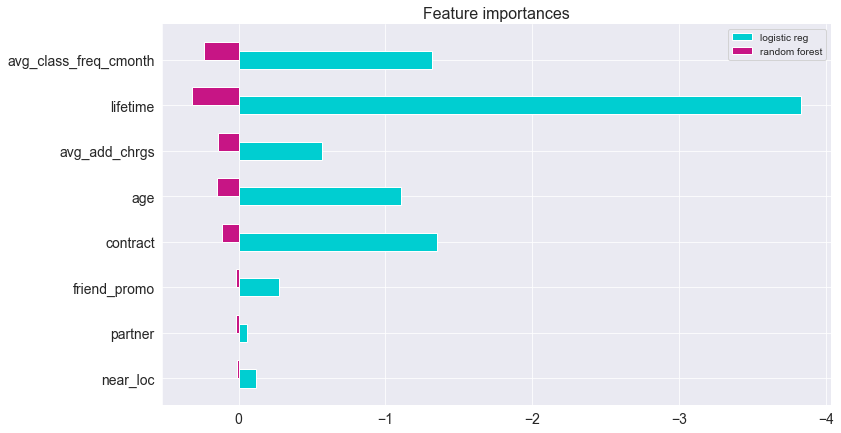

In [31]:
#Set style
sns.set_style('darkgrid')

#Create plot
fig, ax = plt.subplots(figsize=(12,7))

#Plot importances for the logistic regression model
ax.barh(feats, features.lr_feat,
        color = 'darkturquoise',
        label = 'logistic reg',
        height=.4
       )

#Plot importances for the random forest model
ax.barh(feats, features.rfc_feat,
        color = 'mediumvioletred',
        label = 'random forest',
        height=.4, align='edge'
       )

plt.title('Feature importances', size=16)
plt.tick_params(axis='both', labelsize=14)

ax.invert_xaxis()
plt.legend()
sns.despine()

The top features to consider seem to be lifetime, contract length, the member's recent class attendance, money spent, and age. Newer members seem to be at higher risk of churn, so the other features should be strongly considered to determine how invested a member is (time & money spent, as well as time & money committed).

[Return to Table of Contents](#toc)

<a class='anchor' id='cluster'></a>
## 6. Member clustering

Create member clusters using KMeans clustering to allow for further analysis into common features of different member types.

<a class='anchor' id='id_clusters'></a>
### 6.1 Identify member clusters

Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram.

In [32]:
linked = linkage(X_sc, method = 'ward')

**Plot dendrogram**

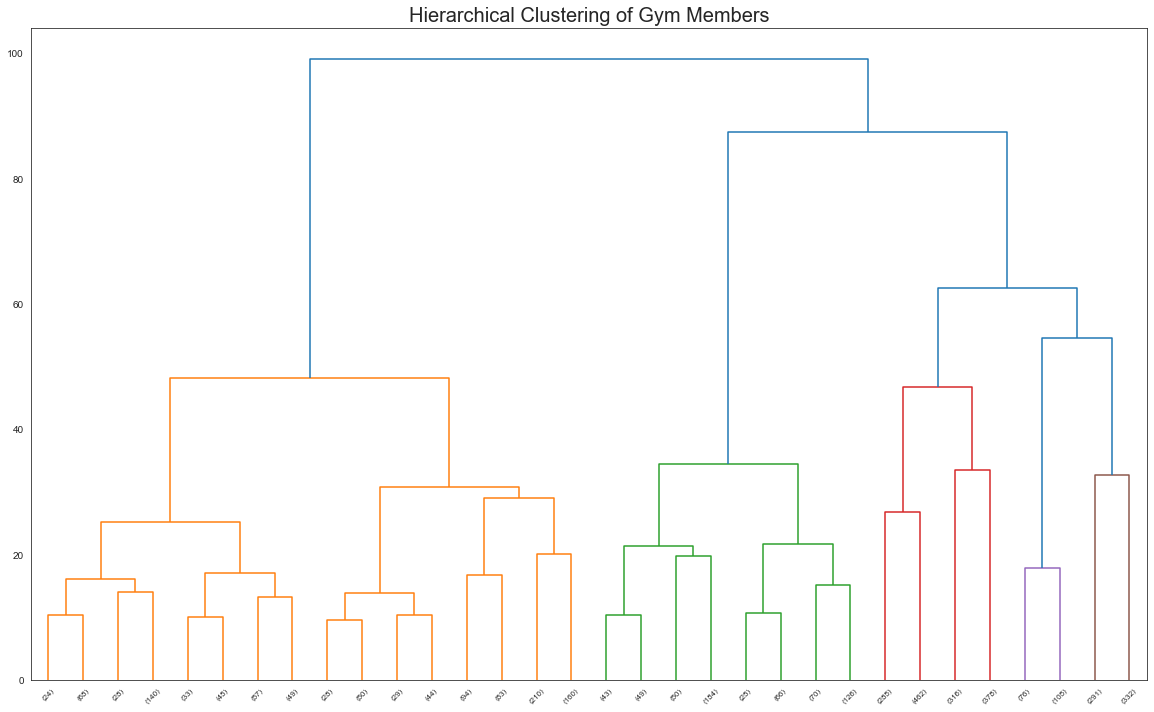

In [33]:
#Set style
sns.set_style('white')
#Create dendrogram
plt.figure(figsize=(20,12))
dendrogram(linked, orientation='top', color_threshold=50,
           truncate_mode='level', p=4)
#Title
plt.title('Hierarchical Clustering of Gym Members', size=20)

plt.show()

**Train the clustering model with the K-means algorithm to predict customer clusters.**

In [34]:
# Train model
km = KMeans(n_clusters=5,random_state=0)
# Save cluster labels
labels = km.fit_predict(X_sc)
# Add cluster labels to the member data
gym_churn['cluster'] = labels

[Return to Table of Contents](#toc)

<a class='anchor' id='cluster_feat'></a>
### 6.2 Cluster features

Explore the features of the typical members of each cluster. Only explore features present in the training model.

<a class='anchor' id='avg_feat'></a>
#### Average feature values by cluster

In [42]:
#Relevant columns 
cluster_feats = model_feat + ['avg_class_freq_total','cluster', 'churn']
#Agg table of feature maens for each cluster 
means = gym_churn[cluster_feats].groupby('cluster').mean().T
#Add the overall mean values
means['all'] = gym_churn[cluster_feats].mean().T
means

cluster,0,1,2,3,4,all
near_loc,0.000000,0.998767,0.993210,1.000000,0.996350,0.845250
partner,0.486043,0.144266,0.938894,0.226773,0.618613,0.486750
friend_promo,0.070608,0.085080,1.000000,0.090909,0.000000,0.308500
age,28.689655,30.747226,29.600388,27.334665,30.016423,29.184250
avg_add_chrgs,137.293885,178.402339,153.911336,111.069102,163.532625,146.943728
lifetime,2.990148,5.766954,4.248303,1.555445,4.496350,3.724750
avg_class_freq_cmonth,1.591302,2.335921,1.906584,1.108890,2.060192,1.767052
avg_class_freq_total,1.762430,2.332173,1.950933,1.402263,2.073522,1.879020
churn,0.403941,0.036991,0.118332,0.641359,0.038321,0.265250


At first look, most clusters are partly defined by the complete absence or presence of a particular feature.

**Cluster 0** members exclusively live & work out of the area. Otherwise, **all clusters** are mainly composed of customers who ***live or work nearby***. **Cluster 2** members were exclusively brought in through the _Bring-a-Friend_ promotion. **Cluster 3** members exlusively live in the area. None of the **Cluster 4** members were brought in through the friend promo.

**Cluster 1** is the only cluster that does not appear to fit this pattern, though it had several other defining features such as being the highest spenders with the longest lifetime.

We will explore the features in greater depth by graphing feature distributions.

In [37]:
#Palette for consistent coloring through all graphs
cluster_palette = {0:'dodgerblue', 1:'gold', 2:'limegreen',
                   3:'crimson', 4:'blueviolet','all':'lightgray'
                  }
#Set style back to whitegrid
sns.set_style('whitegrid')

<a class='anchor' id='cluster_dist'></a>
#### Categorical feature distributions by cluster


In [36]:
#List of quantitative features
model_quant_feat = ['age','avg_add_chrgs','lifetime','avg_class_freq_cmonth']
#Remove all quantitative features from 'means' for graphing of categorical features
#Stack the remaining columns
cluster_means = means.drop(model_quant_feat+['avg_class_freq_total']).stack().reset_index()
#Rename columns
cluster_means.columns = ['feat','cluster','mean']

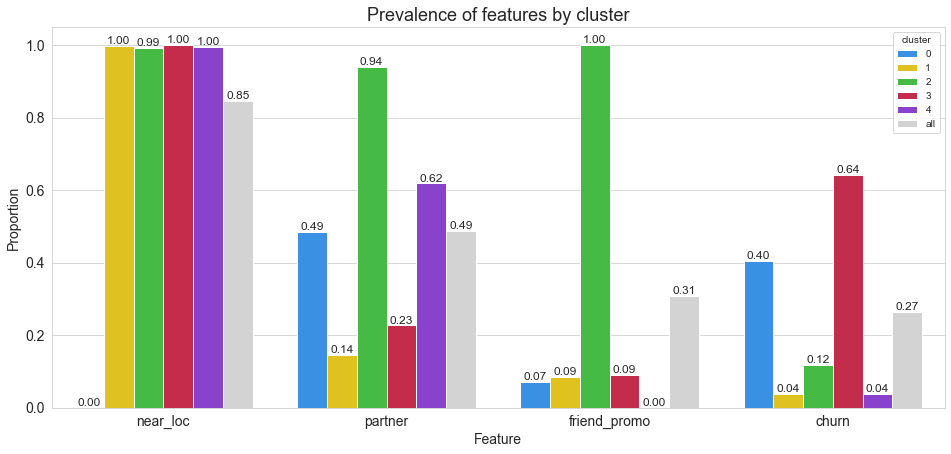

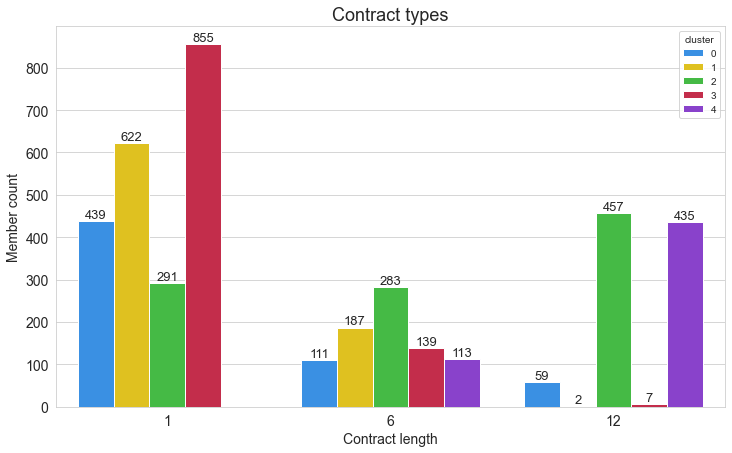

In [41]:
##Comparative bar chart of all binary features by cluster
fig = plt.figure(figsize=(16,7))
ax = sns.barplot(data=cluster_means,
                 x= 'feat', y= 'mean',
                 hue = 'cluster',
                 palette = cluster_palette
                )
#Titles & labels
plt.title('Prevalence of features by cluster', size=18)
plt.tick_params(labelsize = 14)
plt.xlabel('Feature', size=14)
plt.ylabel('Proportion', size=14)
#Annotate bars
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', size=12)
plt.show()


##Comparative bar chart of contract types per cluster
fig = plt.figure(figsize=(12,7))  
ax = sns.countplot(data = gym_churn,
                   x = 'contract',
                   hue='cluster',
                   palette = cluster_palette
                  )
#Titles & labels
plt.title('Contract types', size=18)
plt.tick_params(labelsize = 14)
plt.xlabel('Contract length', size=14)
plt.ylabel('Member count', size=14)
#Annotate bars
for bars in ax.containers:
        ax.bar_label(bars, size=13)
plt.show()

#### Quantitative features by cluster

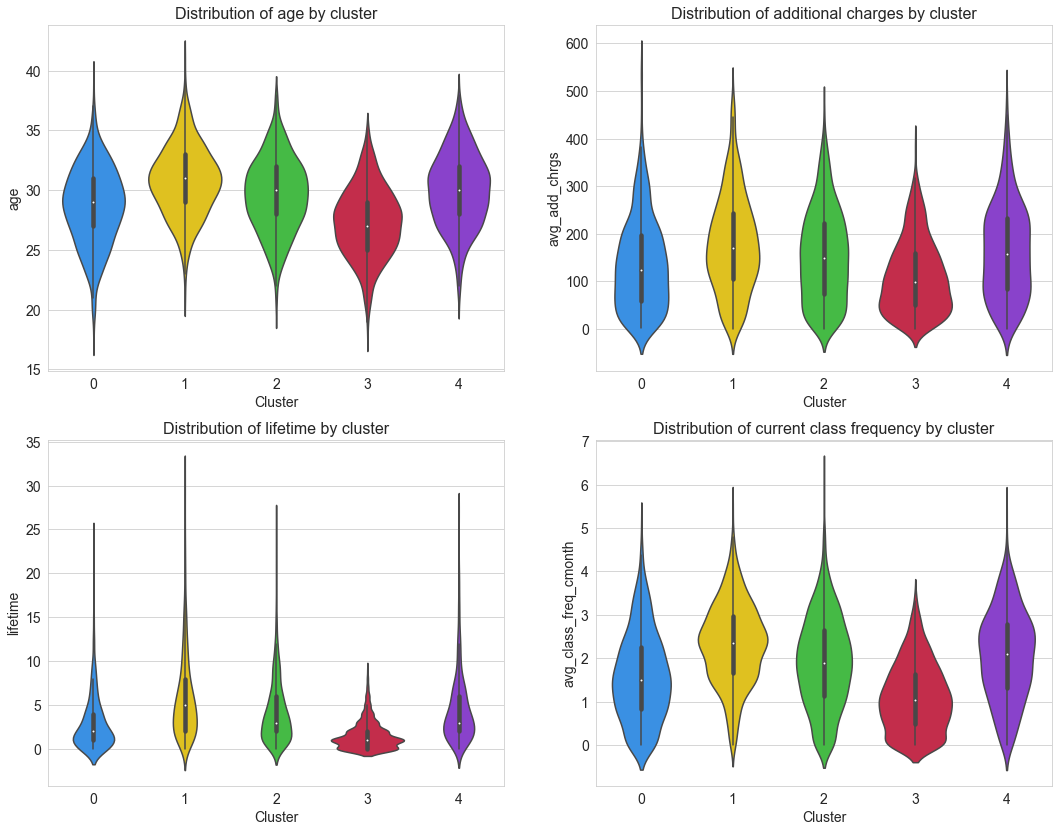

In [39]:
##Plot distributions of all continuous features in the model by cluster

def violin_sub(feat,ax):
    '''Function to create stylistically identical violinplot subplots
    '''
    ax = sns.violinplot(data = gym_churn, y= feat, x= 'cluster', palette = cluster_palette, ax=ax)
    
    title = 'Distribution of {} by cluster'.format(quant_feat[feat])
    ax.set_title(title, size=16)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Cluster', size=14)
    ax.set_ylabel(feat, size=14)
    
#Create a fig with 4 subplots
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(18,14))

#Iterate through the axes and assign features to plot using violin_sub
n=0
for ax in axes.flatten():
    feat = model_quant_feat[n]
    violin_sub(feat,ax)
    n+=1


#### Cluster analysis

**Cluster 0**<br>
Members do not live or work nearby, and have the **second highest rate of churn** (40%). Nearly half of these members were brought in by partner programs, though they overwhelmingly choose short-term contracts. Money saved on partner programs may have incentivized customers who otherwise would not have chosen this gym. Though ultimately the inconvenience of not living nearby may be the reason they don't stay. Age, additional charges, and class frequency are all widely spread; though they do all average lower than the overall average. It may be worth further investigating what brought in the members who did not join due to partner programs. Maybe they have friends, family, or temporary work commitments in the area. Maybe they are interested in specific classes offered. Understanding this may help us decide whether to put resources toward trying to maintain these customers.

**Cluster 1**<br>
This is our **lowest churn group** at a 3.7% churn rate. Members in this cluster have the highest average age, longest average lifetime, highest class engagement, and spend the most on average. Though despite this commitment, they still heavily favor monthly contracts. 

**Cluster 2**<br>
The social cluster. These members were exclusively brought in by the _Bring-a-Friend_ promotion. They are also the most likely to be part of a partner program (94%). Members choose monthly and 6-month contracts at roughly equal rates, but favor 1-year contracts. They are more engaged in group classes than average, but not significantly. They are otherwise somewhat average compared to the overall group. Almost 12% of this cluster has discontinued membership, though there is no clear reason. We should consider studying the reasons for churn in this group.

**Cluster 3**<br>
The high-churn group. These members exclusively live/work nearby. They are the youngest on average, spend the least money, attend the fewest classes, and account for the highest share of monthly contracts. Very few members in this group came in with the friend promo. Encouraging attendance to group classes and incentives for bringing in friends may help this group maintain their commitment to the gym.

The younger age of this group as well as the fact that less than a quarter of these members are part of a partner program may imply that these customers simply can't keep up with the cost of gym memberships. It is also possible that many in this group have less stable careers that make it diffcult to maintain a commitment. We should do further research into the demographics of this group to understand if there are ways to reduce churn. 

**Cluster 4**<br>
This group has the **second-lowest rate of churn** at only 3.8%. None of them came in through the friend promotion, but roughly 62% are part of a partnership program. These are committed members with no monthly contracts, and nearly 80% of them opt for 1-year contracts. They are similar to **cluster 1** in age, spending, and class frequency. Partner promotions may be effective in attracting stable, long-term customers for longer contracts. 

[Return to Table of Contents](#toc)

<a class='anchor' id='conclusions'></a>
## Final Conclusions

Convenience seems to play a large role in maintaining memberships. People are more likely to stay if they live or work nearby. Those with long-term contracts tend to stay loyal. Those who have a partner membership tend to opt for these more long-term contracts

Social engagement also seems to play a role. Members brought in by friends tend toward long-term contracts and maintain their class frequency. Members whose class frequency decreases appear to be at risk of leaving, while members engaged in group classes are geneally high-value customers at low risk of churn. Increasing class engagement may help reduce churn.

Strategies to consider:
- Limit marketing to individuals & businesses nearby.
- Increase partner programs with businesses nearby
- Continue encouraging members to bring in friends with incentives
- Promote group classes
- Engage with & incentivize members who have had a noticeable drop in class attendance 

[Return to Table of Contents](#toc)